## Business & Data Understanding

My goal is to build models that Twitter can use for sentiment analysis. Twitter would use these models to categorize tweets into positive or negative, and share this information with companies that might be interested to learn more about how customers are reacting to their products. I will be using a dataset comprised of 9,000 tweets from customers of either Apple or Google products.

## Data Preparation

In [68]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [69]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')

In [70]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


There appear to be many null values in the 'emotion_in_tweet_is_directed_at' column. I will further investigate those values shortly to understand how I should be handling them. 

In [72]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

Each unique value in this column seems to classify the emotion in the tweet as either directed at a Google product or an Apple product. Since there is not an 'Other' value of sorts, I assume that the null values are directed at something non-product related, or that there simply is on emotion in the tweet. I can confirm this by further investigating the dataset.

In [73]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

There appear to be a few categories for this yes or no question. To keep things simple, I will subset the data to only include either 'Positive emotion' or 'Negative emotion'. This will allow me to build a binary classifier. Let's also see how that impacted the null values we noticed.

In [74]:
binary_df = df[(df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion') | 
               (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion')]

binary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3548 entries, 0 to 9088
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          3548 non-null   object
 1   emotion_in_tweet_is_directed_at                     3191 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  3548 non-null   object
dtypes: object(3)
memory usage: 110.9+ KB


Turning this dataset into a binary one seems to have addressed a majority of the null values we saw originally in the 'emotion_in_tweet_is_directed_at' column. However, there are still over 300 null values in that column. Let's take a closer look to see what those might be.

In [75]:
binary_df_nulls = binary_df[binary_df['emotion_in_tweet_is_directed_at'].isna() == True]
binary_df_nulls

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
46,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...,NaN,Positive emotion
64,Again? RT @mention Line at the Apple store is ...,NaN,Negative emotion
68,Boooo! RT @mention Flipboard is developing an ...,NaN,Negative emotion
103,Know that &quot;dataviz&quot; translates to &q...,NaN,Negative emotion
112,Spark for #android is up for a #teamandroid aw...,NaN,Positive emotion
...,...,...,...
9011,apparently the line to get an iPad at the #sxs...,NaN,Positive emotion
9043,Hey is anyone doing #sxsw signing up for the g...,NaN,Negative emotion
9049,@mention you can buy my used iPad and I'll pic...,NaN,Positive emotion
9052,@mention You could buy a new iPad 2 tmrw at th...,NaN,Positive emotion


In [76]:
binary_df_nulls['tweet_text'][64]

'Again? RT @mention Line at the Apple store is insane.. #sxsw'

In [77]:
binary_df_nulls['tweet_text'][68]

'Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw'

In [78]:
binary_df_nulls['tweet_text'][103]

"Know that &quot;dataviz&quot; translates to &quot;satanic&quot; on an iPhone. I'm just sayin'. #sxsw"

For the above 3 examples - it seems as though there is an emotion and mention of Google or Apple, but the emotion is not necessarily directed at the companies or their products. As such, I will drop these cases since they do not tell us how a customer felt either positively or negatively about the companies or products.

In [79]:
binary_df_nonulls = binary_df.dropna()
binary_df_nonulls = binary_df_nonulls.drop(columns = 'emotion_in_tweet_is_directed_at')
binary_df_nonulls['is_there_an_emotion_directed_at_a_brand_or_product'] = binary_df_nonulls['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 0 if x == 'Negative emotion' else 1)
binary_df_nonulls

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1
...,...,...
9077,@mention your PR guy just convinced me to swit...,1
9079,&quot;papyrus...sort of like the ipad&quot; - ...,1
9080,Diller says Google TV &quot;might be run over ...,0
9085,I've always used Camera+ for my iPhone b/c it ...,1


## Data Pre-Processing
Now that we have turned the dataset into a binary one, I will take further pre-processing steps ahead of modeling. I will adddress the following in the 'tweet_text' column:

- Capitalization
- Apostrophes
- Numbers
- Stopwords

In [80]:
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
import string
import re
from sklearn.model_selection import train_test_split

First I will separate the dataset into Train and Test sets so as to avoid any data leakage. We want to maintain the sanctity of the Test set to simulate truly 'unseen' data.

In [81]:
X = pd.DataFrame(binary_df_nonulls['tweet_text'])
y = pd.DataFrame(binary_df_nonulls['is_there_an_emotion_directed_at_a_brand_or_product'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Next, I will change all of the tweets to lowercase to ensure on duplication of the same words with different capitlization.

In [82]:
X_train ['tweet_text'] = X_train['tweet_text'].str.lower()
X_train ['tweet_text']

4840    idea is to combine google analytics with other...
487     hey #sxsw exhibitors, why not capture your boo...
14      great #sxsw ipad app from @madebymany: http://...
8795    got a craving? #sxsw minds created an app for ...
1113    they'd be stupid not to. // apple is opening a...
                              ...                        
2931    *g* rt @mention  love the apple pop-up store a...
3024    texas observer tomlinson says they would doubl...
3481    what's behind #android's race to no. 1? {link}...
2340    #sxsw #enchantment: @mention &quot;no one uses...
9035    @mention yes, i picked up the ipad 2 at #sxsw....
Name: tweet_text, Length: 2393, dtype: object

Now that all of the text is lowercase, I can proceed with tokenizing each tweet.

In [83]:
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

X_train['tokenized'] = X_train['tweet_text'].apply(tokenizer.tokenize)
X_train

,tweet_text,tokenized
4840,idea is to combine google analytics with other...,"[idea, is, to, combine, google, analytics, wit..."
487,"hey #sxsw exhibitors, why not capture your boo...","[hey, sxsw, exhibitors, why, not, capture, you..."
14,great #sxsw ipad app from @madebymany: http://...,"[great, sxsw, ipad, app, from, madebymany, htt..."
8795,got a craving? #sxsw minds created an app for ...,"[got, craving, sxsw, minds, created, an, app, ..."
1113,they'd be stupid not to. // apple is opening a...,"[they, be, stupid, not, to, apple, is, opening..."
...,...,...
2931,*g* rt @mention love the apple pop-up store a...,"[rt, mention, love, the, apple, pop, up, store..."
3024,texas observer tomlinson says they would doubl...,"[texas, observer, tomlinson, says, they, would..."
3481,what's behind #android's race to no. 1? {link}...,"[what, behind, android, race, to, no, link, sm..."
2340,#sxsw #enchantment: @mention &quot;no one uses...,"[sxsw, enchantment, mention, quot, no, one, us..."


## Frequency Distributions
I will take a look at the frequency distributions for the entire dataset, and for the Positive and Negative tweets respectively to get a sense for the type of words customers are using.

In [84]:
from nltk import FreqDist
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def visualize_top_20(freq_dist, title):

    # Extract data for plotting
    top_20 = list(zip(*freq_dist.most_common(20)))
    tokens = top_20[0][::-1]
    counts = top_20[1][::-1]
     
    # Set up plot and plot data
    fig, ax = plt.subplots(figsize = (15,8))
    ax.barh(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Tokens")
    ax.tick_params(axis="x")

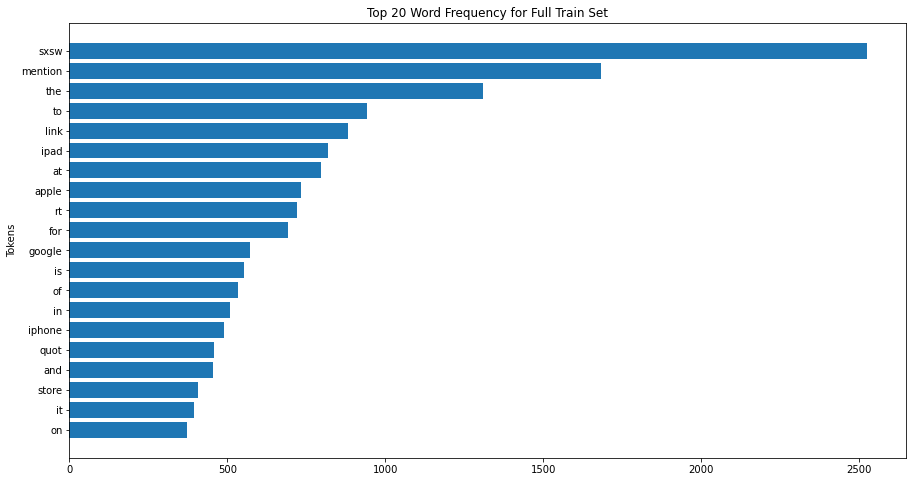

In [85]:
train_freq_dist = FreqDist(X_train['tokenized'].explode())
visualize_top_20(train_freq_dist, 'Top 20 Word Frequency for Full Train Set')

In [86]:
y_train_positive = y_train[y_train['is_there_an_emotion_directed_at_a_brand_or_product'] == 1].index
X_train_positive = X_train[X_train.index.isin(y_train_positive)]

y_train_negative = y_train[y_train['is_there_an_emotion_directed_at_a_brand_or_product'] == 0].index
X_train_negative = X_train[X_train.index.isin(y_train_negative)]

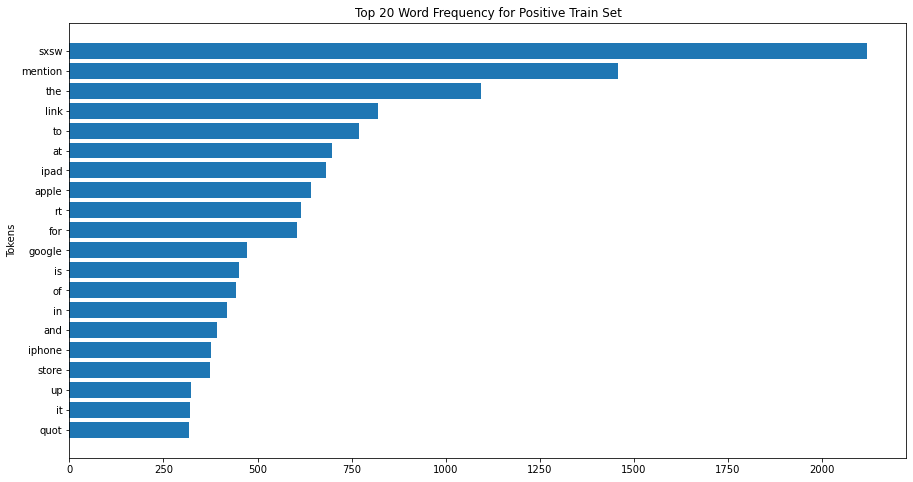

In [87]:
train_freq_dist_positive = FreqDist(X_train_positive['tokenized'].explode())
visualize_top_20(train_freq_dist_positive, 'Top 20 Word Frequency for Positive Train Set')

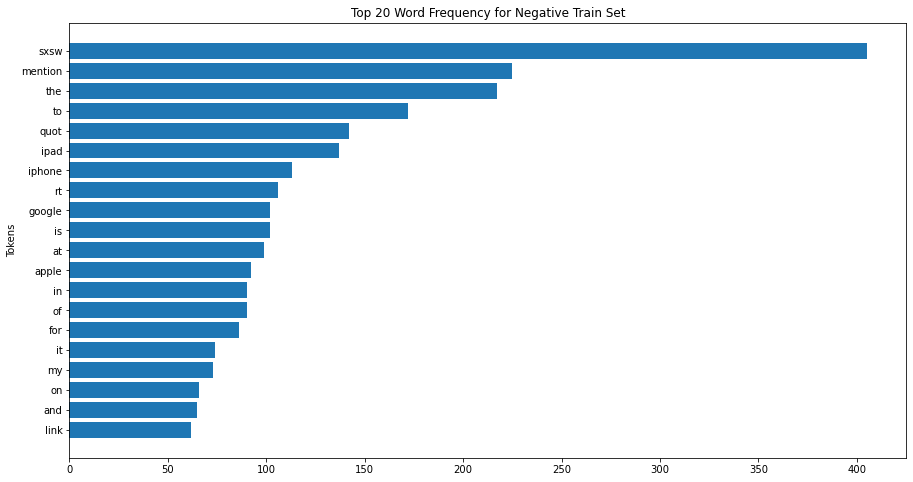

In [88]:
train_freq_dist_negative = FreqDist(X_train_negative['tokenized'].explode())
visualize_top_20(train_freq_dist_negative, 'Top 20 Word Frequency for Negative Train Set')

The frequency distributions we produced above are not very interesting because they contain stopwords. I will fit my baseline model on the dataset that contains stopwords, however I will eventually remove them and see how that improves model performance. At that point we can also take a look at how removing stopwords impacts our word frequency distributions.

## Fit baseline Model

Before fitting my baseline model, I will need to use TfidVectorizer to transform my dataset into matrix format. In doing so I am generating Term-Frequency Inverse Document-Frequency scores which essentially measure the importance of words in the context of other words in a corpus. In this case our corpus is the collection of tweets. 

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features = 20)
X_train_vectorized = tfidf.fit_transform(X_train['tweet_text'])
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,and,apple,at,for,google,in,ipad,iphone,is,it,link,mention,of,on,quot,rt,store,sxsw,the,to
0,0.0,0.000000,0.000000,0.000000,0.40709,0.000000,0.000000,0.00000,0.829190,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.162707,0.000000,0.346769
1,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.686595,0.00000,0.000000,0.0,0.651188,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.323331,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.904703,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.426042,0.000000,0.000000
3,0.0,0.000000,0.000000,0.563453,0.00000,0.000000,0.000000,0.62451,0.000000,0.0,0.484413,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.240523,0.000000,0.000000
4,0.0,0.314602,0.000000,0.323379,0.00000,0.366641,0.293133,0.00000,0.351747,0.0,0.278017,0.230680,0.000000,0.0,0.000000,0.000000,0.38750,0.138042,0.257097,0.294203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2388,0.0,0.321852,0.616229,0.330832,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.235996,0.000000,0.0,0.000000,0.324422,0.39643,0.141223,0.263021,0.000000
2389,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.904703,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.426042,0.000000,0.000000
2390,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,0.650069,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.322775,0.000000,0.687915
2391,0.0,0.155738,0.000000,0.000000,0.00000,0.181499,0.000000,0.00000,0.174125,0.0,0.000000,0.114193,0.179144,0.0,0.928807,0.000000,0.00000,0.068335,0.000000,0.000000


Now that I have a Sparse Matrix, I can fit my machine learning model. I will first test a Random Forest Classifier to see how it performs.

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

baseline_model = RandomForestClassifier()

baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

array([0.82881002, 0.83716075, 0.81210856, 0.84309623, 0.84100418])

In [91]:
baseline_cv.mean()

0.8324359500703172

Although the above Accuracy score is quite promising, we must keep in mind the class imbalance between Positive and Negative tweets.

In [92]:
y_train.value_counts(normalize=True)

is_there_an_emotion_directed_at_a_brand_or_product
1                                                     0.835353
0                                                     0.164647
dtype: float64

This means that if our model predicted Positive for all instances, it would end up with an Accuracy score very similar to the one we produced above.

## Removing Stop Words and Punctuation

For my next iteration, I will remove stop words and punctuation from the tweets to further consolidate the corpus and hone in on the most important words.

In [93]:
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')
stopwords_list[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

Next I will define a function that takes in a list of tokens and removes any words that are present in the above stop words list.

In [94]:
def remove_stopwords(token_list):
    new_list = []
    for token in token_list:
        if token not in stopwords_list:
            new_list.append(token)
        else:
            continue
    return new_list

In [95]:
X_train["text_without_stopwords"] = X_train["tokenized"].apply(remove_stopwords)

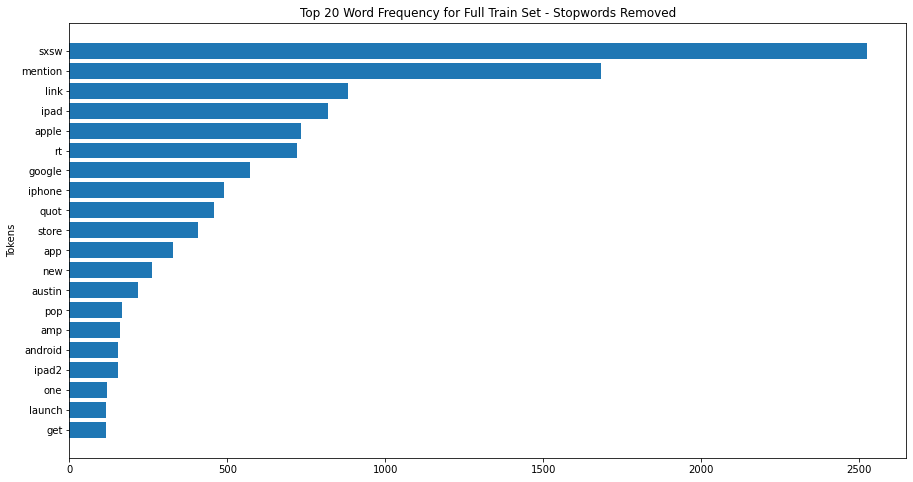

In [96]:
train_freq_dist_stopwords_removed = FreqDist(X_train['text_without_stopwords'].explode())
visualize_top_20(train_freq_dist_stopwords_removed, 'Top 20 Word Frequency for Full Train Set - Stopwords Removed')

We can see that removing the stopwords has made room for new words that are more informative. However, a majority of these words are focused on the companies (Google / Apple) as well as products (ipad for example). These words would be hepful for distinguishing between brands and so it might be worth exploring the option of extending the classification type from binary to multi-class - Positive or Negative with product distinction. To understand which words contribute most to the purely Positive or Negative classification, we would need to remove all brand-specific words as well. Before further iterating, let's see how removing the stopwords impacts model performance.

In [97]:
tfidf2 = TfidfVectorizer(max_features = 20, stop_words = stopwords_list)
X_train_vectorized2 = tfidf2.fit_transform(X_train['tweet_text'])
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized2, columns=tfidf2.get_feature_names())

,amp,android,app,apple,austin,get,google,ipad,ipad2,iphone,launch,link,mention,new,one,pop,quot,rt,store,sxsw
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.928578,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.371136
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.686595,0.0,0.000000,0.000000,0.651188,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.323331
2,0.000000,0.000000,0.793252,0.000000,0.000000,0.0,0.000000,0.550868,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.259415
3,0.000000,0.000000,0.664935,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.564605,0.000000,0.437947,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.217451
4,0.455183,0.000000,0.000000,0.277806,0.418777,0.0,0.000000,0.258848,0.0,0.000000,0.489438,0.245499,0.203699,0.0,0.000000,0.000000,0.000000,0.000000,0.342177,0.121896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2388,0.459205,0.000000,0.000000,0.280260,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.205499,0.0,0.496954,0.455304,0.000000,0.282498,0.345201,0.122974
2389,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.904703,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.426042
2390,0.000000,0.858255,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.459678,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.228241
2391,0.000000,0.000000,0.000000,0.157246,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.115300,0.0,0.278827,0.000000,0.937803,0.000000,0.000000,0.068997


In [98]:
baseline_model_v2 = RandomForestClassifier()

stopwords_removed_cv = cross_val_score(baseline_model_v2, X_train_vectorized2, y_train)
stopwords_removed_cv

array([0.81837161, 0.80793319, 0.82881002, 0.83263598, 0.83054393])

In [99]:
print("Baseline:         ", baseline_cv.mean())
print("Stopwords removed:", stopwords_removed_cv.mean())

Baseline:          0.8324359500703172
Stopwords removed: 0.8236589477729929


Interestingly enough, it seems as though removing stop words actually worsened model performance. This is not very common but could be due to the fact that we are only using individual words at the moment. In future iterations we can extend our model to use n-grams so as to preserve more context between connected words.

Next, I will investigate the impact of stemming words on model performance.

In [100]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [101]:
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [102]:
# Instantiate the vectorizer
tfidf_v3 = TfidfVectorizer(max_features=20, stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized_v3 = tfidf_v3.fit_transform(X_train["tweet_text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_v3, columns=tfidf_v3.get_feature_names())

,amp,android,app,appl,austin,get,go,googl,ipad,ipad2,iphon,launch,link,mention,new,pop,quot,rt,store,sxsw
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.928578,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.371136
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.683206,0.0,0.000000,0.000000,0.653892,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.325045
2,0.000000,0.000000,0.776409,0.000000,0.000000,0.0,0.0,0.000000,0.569103,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.270759
3,0.000000,0.000000,0.858096,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.388182,0.000000,0.300996,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.149623
4,0.461644,0.000000,0.000000,0.281564,0.424722,0.0,0.0,0.000000,0.259849,0.0,0.000000,0.469882,0.248700,0.206489,0.0,0.0000,0.000000,0.000000,0.345158,0.123627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2388,0.530166,0.000000,0.000000,0.323356,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.237139,0.0,0.5239,0.000000,0.326153,0.396390,0.141977
2389,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.903010,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.429620
2390,0.000000,0.858463,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.459263,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.228296
2391,0.000000,0.000000,0.000000,0.163847,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.120160,0.0,0.0000,0.976494,0.000000,0.000000,0.071941


In [103]:
baseline_model_v3 = RandomForestClassifier()

stemmed_cv = cross_val_score(baseline_model_v3, X_train_vectorized_v3, y_train)
stemmed_cv

array([0.81628392, 0.82045929, 0.8308977 , 0.83682008, 0.84518828])

In [104]:
# Run this cell without changes
print("Stopwords removed:", stopwords_removed_cv.mean())
print("Stemmed:          ", stemmed_cv.mean())

Stopwords removed: 0.8236589477729929
Stemmed:           0.8299298573562425


Compared to our model with stopwords removed only, this model with both stopwords removed and stemming performed marginally better. However, our baseline model still showed the best performance on average. Before further iterating, let's take a closer look at our model's predictions to see on which cases it performed well, and which cases it performed poorly.

In [105]:
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_curve, auc, roc_auc_score, balanced_accuracy_score

baseline_model_v3.fit(X_train_vectorized_v3, y_train)

# Fit the vectorizer on X_train["text"] and transform it
X_test_vectorized_v3 = tfidf_v3.fit_transform(X_test["tweet_text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_v3, columns=tfidf_v3.get_feature_names())

y_hat = baseline_model_v3.predict(X_test_vectorized_v3)

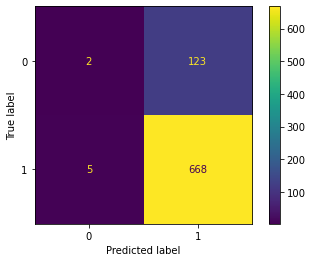

In [106]:
cm = confusion_matrix(y_test, y_hat, labels = baseline_model_v3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=baseline_model_v3.classes_)
disp.plot()
plt.show()

It looks like the model is not learing and predicting negative sentiment cases well. This is likely due to the class imbalance we mentioned earlier. We can confirm or deny this by addressing the class imbalance with random over sampling.

In [107]:
from imblearn.over_sampling import RandomOverSampler

In [108]:
X_train, X_test, y_train, y_test = train_test_split(binary_df_nonulls['tweet_text'], binary_df_nonulls['is_there_an_emotion_directed_at_a_brand_or_product'].values, test_size=0.25)

In [109]:
from collections import Counter

In [110]:
Counter(y_train)

Counter({1: 2002, 0: 391})

In [111]:
vectorizer = TfidfVectorizer(stop_words=stemmed_stopwords)
vectorizer.fit(X_train)

TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'our',
                            'ourselv', 'you', "you'r", "you'v", "you'll",
                            "you'd", 'your', 'your', 'yourself', 'yourselv',
                            'he', 'him', 'his', 'himself', 'she', 'she', 'her',
                            'her', 'herself', 'it', 'it', 'it', 'itself', ...])

In [112]:
X_train_tf = vectorizer.transform(X_train)

In [113]:
X_train_tf = X_train_tf.toarray()

In [114]:
X_test_tf = vectorizer.transform(X_test)
X_test_tf = X_test_tf.toarray()

In [115]:
ROS = RandomOverSampler(sampling_strategy=1)
X_train_ros, y_train_ros = ROS.fit_resample(X_train_tf, y_train)

In [116]:
Counter(y_train_ros)

Counter({1: 2002, 0: 2002})

We can see now that the training dataset's classes are equally balanced. Next I will fit a Gaussian Naive Bayes model to see how Random Over Sampling has impacted performance. The reason I am using Gaussian Naive Bayes is because it is much less computationally expensive to use on our now artificially increased dataset.

In [117]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_ros, y_train_ros)
y_preds = nb.predict(X_test_tf)

print(accuracy_score(y_test, y_preds))

0.7531328320802005


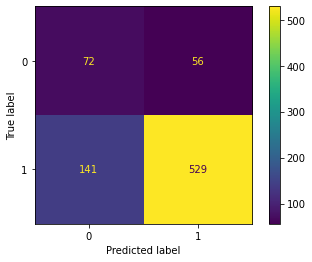

In [118]:
cm = confusion_matrix(y_test, y_preds, labels = nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb.classes_)
disp.plot()
plt.show()

We can see from the confusion matrix above that Random Over Sampling has led our model to make more Negative classifications. On the one hand this has increased the number of truly Positive cases being classified as Negative. On the other hand this has increased the number of truly Negative cases being correctly classified as Negative.

Next I will investigate how incorporating Bigrams impacts model performance.

## Creating Bigrams

I will follow all of the same steps that I did previously to fit a new model. The only difference is that I will indicate in my tfidfVectorizer an ngram range of 1-2 which essentially has the model consider both words individually, as well as bigrams (words with their most closely associated next word).

0.843358395989975


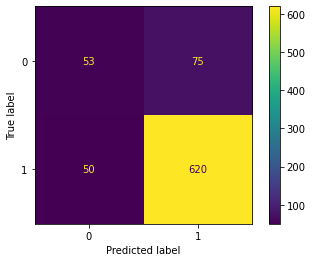

In [119]:
vectorizer = TfidfVectorizer(stop_words=stemmed_stopwords, ngram_range = (1,2))
X_train = X_train.str.lower()
vectorizer.fit(X_train)
X_train_tf = vectorizer.transform(X_train)
X_train_tf = X_train_tf.toarray()
X_test_tf = vectorizer.transform(X_test)
X_test_tf = X_test_tf.toarray()
ROS = RandomOverSampler(sampling_strategy=1)
X_train_ros, y_train_ros = ROS.fit_resample(X_train_tf, y_train)

from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_ros, y_train_ros)
y_preds = nb.predict(X_test_tf)

print(accuracy_score(y_test, y_preds))

cm = confusion_matrix(y_test, y_preds, labels = nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb.classes_)
disp.plot()
plt.show()

As we can see, incorporating Bigrams improved model performance significantly on the test dataset (almost 10%). This is a good accuracy score. Let's next see how we can extend our model's classification abilities by incorporating neutral sentiment and brand distinction.

## Incorporate Neutral Sentiment

In an effort to make this model a bit more sophistocated, I will extend it from binary classification to multi-class. I will include tweets with neutral sentiment and give the model an opportunity to learn this new class.

In [120]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
df_neutral = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

df_neutral_nonulls = df_neutral.dropna()
df_neutral_nonulls = df_neutral_nonulls.drop(columns = 'emotion_in_tweet_is_directed_at')
df_neutral_nonulls['is_there_an_emotion_directed_at_a_brand_or_product'] = df_neutral_nonulls['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 0 if x == 'Negative emotion' else 1 if x == 'Positive emotion' else 2)
df_neutral_nonulls['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

1    2672
0     519
2      91
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

Now that our multi-class dataframe is ready, I will follow the same pre-processing steps that I did for previous iterations of the model.

In [121]:
X_train, X_test, y_train, y_test = train_test_split(df_neutral_nonulls['tweet_text'], df_neutral_nonulls['is_there_an_emotion_directed_at_a_brand_or_product'].values, test_size=0.25)

In [122]:
def process(X_train, X_test, y_train, y_test):
    vectorizer = TfidfVectorizer(stop_words=stemmed_stopwords, ngram_range = (1,2))
    vectorizer.fit(X_train)
    X_train_tf = vectorizer.transform(X_train)
    X_train_tf = X_train_tf.toarray()
    X_test_tf = vectorizer.transform(X_test)
    X_test_tf = X_test_tf.toarray()
    ROS = RandomOverSampler(sampling_strategy = 'auto')
    X_train_ros, y_train_ros = ROS.fit_resample(X_train_tf, y_train)
    
    nb = GaussianNB()
    nb.fit(X_train_ros, y_train_ros)
    y_preds = nb.predict(X_test_tf)

    print(accuracy_score(y_test, y_preds))

    cm = confusion_matrix(y_test, y_preds, labels = nb.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nb.classes_)
    disp.plot()
    plt.show()

0.833130328867235


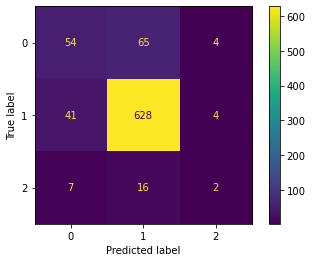

0: Negative Emotion
1: Positive Emotion
2: Neutral Emotion


In [123]:
process(X_train, X_test, y_train, y_test)
print('0: Negative Emotion')
print('1: Positive Emotion')
print('2: Neutral Emotion')

An accuracy score of 85% is very promising. However, this is a bit misleading in that the model performed very poorly on the "Neutral Emotion" class, and also relatively poorly on the "Negative Emotion" class. This could be due to multiple reasons. Firstly, the class balance was heavily skewed towards the "Positive Emotion" class. I had to use oversampling to create synthetic datapoints for the other classes to match the "Negative Emotion" class in volume. Secondly, this could imply that positive words are more distinguishing than negative and neutral words in this dataset.

## Incorporate Product Specific Sentiment (Google vs. Apple)

I would like to improve model performance on minority classes, but first I am interested to see how further complicating our model affects performance. I will extend multi-class categories even further to include brand-specific classification. Knowing that the actual brand names are mentioned heavily in the tweets, I am interested to see how well our model can distinguish between both brands and sentiment.

In [57]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

First I will need to make "emotion_in_tweet_is_directed_at" binary (either Google or Apple).

In [65]:
df_brand_multiclass = df.dropna()
df_brand_multiclass = df_brand_multiclass[df_brand_multiclass['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]
df_brand_multiclass['emotion_in_tweet_is_directed_at'] = df_brand_multiclass['emotion_in_tweet_is_directed_at'].apply(
lambda x: 'Apple' 
if 'iP' in x or 'Apple' in x
else 'Google' if 'Google' in x or 'Android' in x
else 'N/A')

df_brand_multiclass['emotion_in_tweet_is_directed_at'].value_counts()

Apple     2402
Google     880
Name: emotion_in_tweet_is_directed_at, dtype: int64

Next I will define a function that generates the new classifications using information from both columns. This function will use the newly-defined binary brand distinction in conjunction with multi-class sentiment (Positive, Negative, Neutral).

In [59]:
def conditions(df):
    if (df['emotion_in_tweet_is_directed_at'] == 'Apple') and (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion'):
        return 'Apple Positive'
    elif (df['emotion_in_tweet_is_directed_at'] == 'Apple') and (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion'):
        return 'Apple Negative'
    elif (df['emotion_in_tweet_is_directed_at'] == 'Google') and (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion'):
        return 'Google Positive'
    elif (df['emotion_in_tweet_is_directed_at'] == 'Google') and (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion'):
        return 'Google Negative'
    elif (df['emotion_in_tweet_is_directed_at'] == 'Apple') and (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product'):
        return 'Apple Neutral'
    elif (df['emotion_in_tweet_is_directed_at'] == 'Google') and (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product'):
        return 'Google Neutral'
    else:
        return 'NA'

In [60]:
df_brand_multiclass['is_there_an_emotion_directed_at_a_brand_or_product'] = df_brand_multiclass.apply(conditions, axis=1)
df_brand_multiclass

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Apple Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Apple Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Apple Positive
3,@sxsw I hope this year's festival isn't as cra...,Apple,Apple Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Google Positive
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,Apple,Apple Positive
9079,&quot;papyrus...sort of like the ipad&quot; - ...,Apple,Apple Positive
9080,Diller says Google TV &quot;might be run over ...,Google,Google Negative
9085,I've always used Camera+ for my iPhone b/c it ...,Apple,Apple Positive


In [66]:
df_brand_multiclass['is_there_an_emotion_directed_at_a_brand_or_product'] = df_brand_multiclass['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 
0 if x == 'Apple Positive' 
else 1 if x == 'Apple Negative' 
else 2 if x == 'Google Positive'
else 3 if x == 'Google Negative' 
else 4 if x == 'Apple Neutral' 
else 5)

Now that our new dataframe is ready, I will follow the same pre-processing and modeling steps as before.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(df_brand_multiclass['tweet_text'], df_brand_multiclass['is_there_an_emotion_directed_at_a_brand_or_product'].values, test_size=0.25)

0.756394640682095


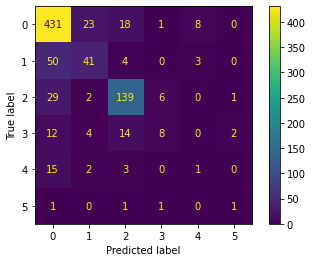

0: Apple Positive
1: Apple Negative
2: Google Positive
3: Google Negative
4: Apple Neutral
5: Google Neutral


In [63]:
process(X_train, X_test, y_train, y_test)
print('0: Apple Positive')
print('1: Apple Negative')
print('2: Google Positive')
print('3: Google Negative')
print('4: Apple Neutral')
print('5: Google Neutral')

Not surprisingly, this model's performance mirrors that of the previous one in that it was best at correctly predicting positive sentiment (for both Google and Apple). It also seems like the model has a good handle on distinguishing between Google and Apple - we can see this reflected in the most commonly confused predictions for each class (i.e "Apple Positive" is most commonly confused with "Apple Negative", and "Google Negative" is most commonly confused with "Google Positive"). We do see the class imbalance predictive performance playing a part here as well (i.e. "Google Positive" was most commonly confused with "Apple Positive".

In order to help our model learn the differences between brands and sentiment, let's further cleanup our bag of words.

In [64]:
# Custom Tokens? i.e. removing sxsw